# Establish Relations 

In [1]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader
#Import numpy for array calculation
import numpy as np

import re

#import nltk for string operations
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

import relations

In [2]:
# Load the model
model = gensim.downloader.load('glove-wiki-gigaword-50')
dims = 50

In [58]:
male_female_tuples = relations.read_relations("./relations/male-female.txt")
male_female_tuples, test_tuples = male_female_tuples[:-10], male_female_tuples[-10:]
male_female_tuples

[('Father', 'Mother'),
 ('Son', 'Daughter'),
 ('Brother', 'Sister'),
 ('God', 'goddess'),
 ('Man', 'Woman'),
 ('Bachelor', 'Maid'),
 ('Cock', 'Hen'),
 ('Dog', 'Bitch'),
 ('Bull', 'Cow'),
 ('Drone', 'Bee'),
 ('Gander', 'Goose'),
 ('Waiter', 'Waitress'),
 ('Stag', 'Hind'),
 ('Gentleman', 'Lady'),
 ('Earl', 'Countess'),
 ('Husband', 'Wife'),
 ('Dad', 'mom'),
 ('Lord', 'Lady'),
 ('King', 'Queen'),
 ('Monk', 'Nun'),
 ('Boy', 'Girl'),
 ('Sir', 'Madam'),
 ('Uncle', 'Aunt'),
 ('Nephew', 'Niece'),
 ('Daddy', 'mummy'),
 ('Wizard', 'Witch'),
 ('Hart', 'Roe'),
 ('Drake', 'Duck'),
 ('Lion', 'Lioness'),
 ('Count', 'Countess'),
 ('Giant', 'Giantess'),
 ('Priest', 'Priestess'),
 ('Prophet', 'Prophetess'),
 ('Poet', 'Poetess'),
 ('Patron', 'Patroness'),
 ('Host', 'Hostess'),
 ('Viscount', 'Viscountess'),
 ('Shepherd', 'Shepherdess'),
 ('Steward', 'Stewardess'),
 ('Author', 'Authoress'),
 ('Manager', 'Manageress'),
 ('Bridegroom', 'Bride'),
 ('Jew', 'Jewess'),
 ('Baron', 'Baroness'),
 ('Mayor', 'Mayores

In [4]:
# created a separate list for country-capital word vectors
male_female_vectors = []

for tup in male_female_tuples:
    if tup[0].lower() in model.vocab and tup[1].lower() in model.vocab:
        male_vec = model.get_vector(tup[0].lower())
        female_vec = model.get_vector(tup[1].lower())
        male_female_vectors.append((male_vec, female_vec))


## Relation Visualisation

### Reduction to 3 - dimensions

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

In [6]:
# Reduced dimensionality of word vectors to two

vec_3d = []
start_idx = 0
end_idx = 3
for tup in male_female_vectors:
    vec_3d.append((tup[0][start_idx:end_idx], tup[1][start_idx:end_idx]))

In [7]:
# plot country points
x1 = np.array([a[0] for a,b in vec_3d])
y1 = np.array([a[1] for a,b in vec_3d])
z1 = np.array([a[2] for a,b in vec_3d])
#capital points
x2 = np.array([b[0] for a,b in vec_3d])
y2 = np.array([b[1] for a,b in vec_3d])
z2 = np.array([b[2] for a,b in vec_3d])

<IPython.core.display.Javascript object>


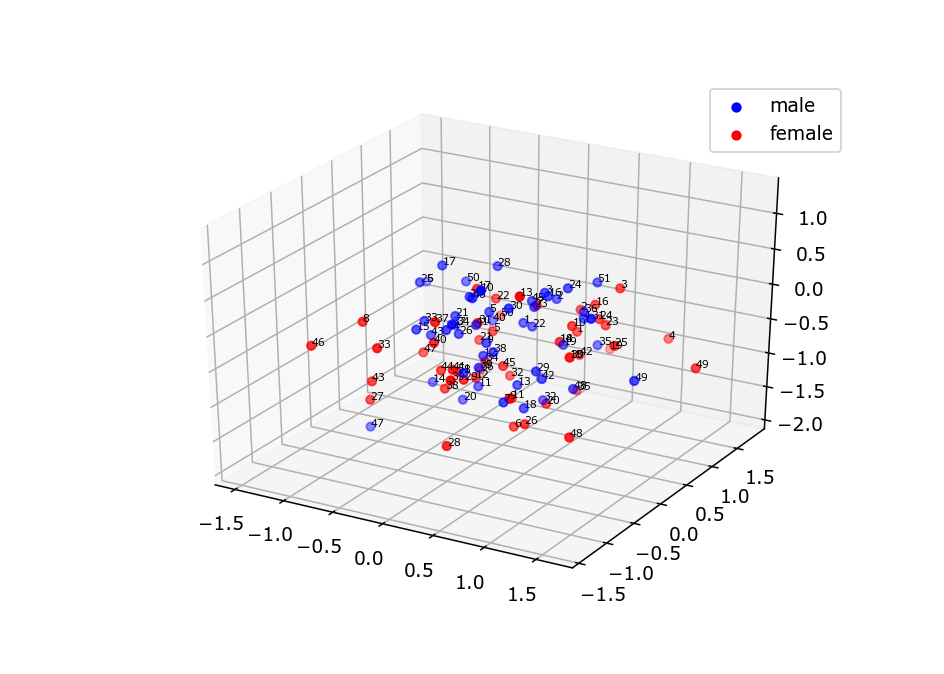

In [8]:
fig = plt.figure(figsize = (7,5))
ax = plt.axes(projection ="3d")

ax.scatter3D(x1,y1,z1, color = 'blue' )
for i in range(len(x1)):
    ax.text(x1[i],y1[i],z1[i], str(i+1), fontsize="xx-small")

ax.scatter3D(x2,y2,z2,color = 'red')
for i in range(len(x1)):
    ax.text(x2[i],y2[i],z2[i], str(i+1), fontsize="xx-small")

plt.legend(["male", "female"])

plt.show()

## Multivariate Multiple Linear Regression

Since we want to establish a relationship between each country vector and capital vector with each vector having 50 dimensions, we'll have to regress separately on each dimension of the dependent variable.

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
model.get_vector("male") # y1 = ax + bx2 + cx3 + c

array([-0.23046  ,  0.65937  , -0.28411  , -0.44366  ,  1.5922   ,
        1.8564   , -0.0054708, -0.58679  , -0.1506   , -0.021166 ,
        1.1029   , -0.79502  ,  1.1899   ,  0.53535  ,  0.25256  ,
       -0.15882  , -0.31825  ,  0.53609  , -0.5944   , -0.21288  ,
       -0.94989  ,  0.91619  ,  0.4879   ,  0.77063  , -0.16215  ,
       -1.0515   , -0.70571  , -0.79814  , -0.79354  , -0.086372 ,
        2.2497   ,  0.68785  , -0.085613 , -0.68004  ,  0.62212  ,
       -0.02536  ,  0.10967  , -0.38748  , -0.62791  , -1.0871   ,
       -0.37412  , -0.061965 ,  0.19225  ,  0.89263  ,  0.51763  ,
       -1.4791   , -0.23219  , -1.1589   ,  0.066075 , -0.038772 ],
      dtype=float32)

In [11]:
# create a coefficients array
coeff = []
intercepts = []
male_vecs = [tup[0] for tup in male_female_vectors]
female_vecs = [tup[1] for tup in male_female_vectors]
avg_score = 0
# regressing a linear model on each independent dimension of response variable
for i in range(dims):
    y = [x[i] for x in female_vecs]
    x = male_vecs
    regr = LinearRegression()
    regr.fit(x, y)
    coeff.append(regr.coef_)
    intercepts.append(regr.intercept_)
    avg_score += regr.score(x,y)
print("Model score: ", avg_score/dims)

Model score:  0.9999999998540906


Each list in coeff represent the coefficients of that particular dimension

In [12]:
# Predicting country vectors from the coefficients
female_vecs_pred = []
for male_vec in male_vecs:
    female_vec = []
    for i in range(dims):
        female_vec.append(sum([a*b for a,b in zip(male_vec,coeff[i])]) + intercepts[i])
    female_vecs_pred.append(np.array(female_vec))

Plotting the predicted and actual values in 3d space

<IPython.core.display.Javascript object>


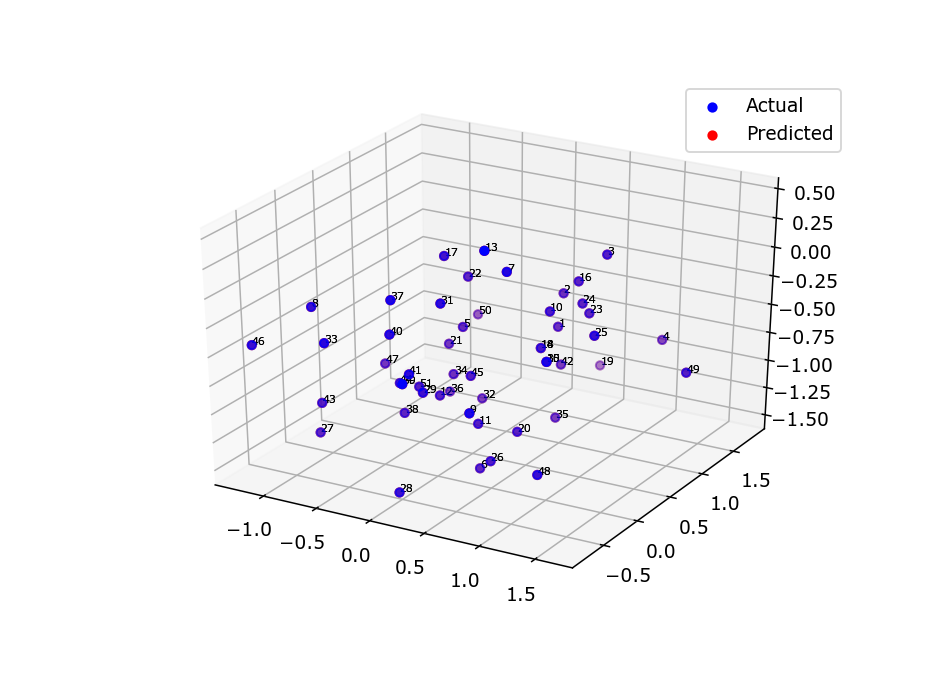

In [13]:
# actual points
x1 = np.array([a[0] for a in female_vecs])
y1 = np.array([a[1] for a in female_vecs])
z1 = np.array([a[2] for a in female_vecs])
# predicted points
x2 = np.array([a[0] for a in female_vecs_pred])
y2 = np.array([a[1] for a in female_vecs_pred])
z2 = np.array([a[2] for a in female_vecs_pred])

# 3d plotting of the points
fig = plt.figure(figsize = (7,5))
ax = plt.axes(projection ="3d")

ax.scatter3D(x1,y1,z1, color = 'blue')
for i in range(len(x1)):
    ax.text(x1[i],y1[i],z1[i], str(i+1), fontsize="xx-small")

ax.scatter3D(x2,y2,z2,color = 'red')
for i in range(len(x1)):
    ax.text(x2[i],y2[i],z2[i], str(i+1), fontsize="xx-small")

plt.legend(["Actual", "Predicted"])

plt.show()

The model predicts actual values almost perfectly

## Taking orthogonal projection of predicted vector to measure accuracy

In [17]:
def predict_output_vector(male):
    female_vec = []
    male_vec = model.get_vector(male)
    for i in range(dims):
        female_vec.append(sum([a*b for a,b in zip(male_vec,coeff[i])]) + intercepts[i])
    return np.array(female_vec)

In [37]:
def calculate_accuracy(true_vector, predicted_vector):
    true_vector_norm = np.sqrt(sum(true_vector**2))    
    proj_of_u_on_v = (np.dot(predicted_vector, true_vector)/true_vector_norm**2)*true_vector
    return 1 - abs(np.linalg.norm(proj_of_u_on_v - true_vector))/np.linalg.norm(true_vector)

In [38]:
def run_test(male, female):
    female = female.lower().strip()
    male = male.lower().strip()
    true_female_vector = model.get_vector(female)
    predicted_female_vector = predict_output_vector(male)
    return calculate_accuracy(true_female_vector, predicted_female_vector)

In [40]:
#test 1
run_test("brother", "sister")

0.9999980864822646

In [41]:
#test 2
run_test("husband", "wife")

0.9999981971918714

In [55]:
#test 3
run_test(test_tuples[2][0], test_tuples[2][1])

0.9186264276504517

In [56]:
#test 4
run_test(test_tuples[3][0], test_tuples[3][1])

-0.49320757389068604

In [52]:
#test 4
run_test(male_female_tuples[10][0], male_female_tuples[10][1])

0.9999973805633999

The model seems to be overfitting

# Polynomial Regression

Since the last model was overfitting, we'll be experimenting with polynomial regression.

In [59]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(degree = 4)
X_poly = poly.fit_transform(X)